# Modèles de prédiction 

Je propose de résumer ici le travail d'exploration fait dans le premier notebook. 

L'objectif est de prédire deux variables numériques : la consommation d'énergie des bâtiments ```SiteEnergyUse(kBtu)```et la quantité d'émission de CO2 ```CO2_emissions```. Après différents pré-traitements tels que l'élimination des variables corrélées entres elles, ou la vectorisation des variables catégorielles, le jeu d'entrainement a la forme suivante : 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_path = "/home/clairegayral/Documents/openclassroom/data/P3/"
res_path = "/home/clairegayral/Documents/openclassroom/res/P3/"

## my .py : 
from P3_preprocess import *
import missing_values_treatment
import duplicates
import univariate_analysis
from multivariate_analysis import *

from sklearn import model_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.impute import KNNImputer
from sklearn import linear_model


In [2]:
data = pd.read_csv(res_path+"cleanned_data.csv", index_col=0)
print(len(data.columns[data.dtypes==float])-3, "training numerical variables : ",
      list(data.columns[data.dtypes==float]))
print(len(data.columns[data.dtypes==int]), 
      "training interger variables (from tokenization of categorical variable)")
data.head()

6 training numerical variables :  ['ZipCode', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 'CO2_emissions', 'age_of_building']
22 training interger variables (from tokenization of categorical variable)


,ZipCode,NumberofBuildings,NumberofFloors,PropertyGFAParking,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),CO2_emissions,age_of_building,BuildingType_0,...,LargestPropertyUseType_2,LargestPropertyUseType_3,LargestPropertyUseType_4,LargestPropertyUseType_5,LargestPropertyUseType_6,LargestPropertyUseType_7,LargestPropertyUseType_8,LargestPropertyUseType_9,LargestPropertyUseType_10,LargestPropertyUseType_11
0,58091.0,1.0,12.0,0.0,88434.0,62.5,7103895.25,249.705,88.5,0,...,0,0,0,0,0,0,0,0,0,1
1,58091.0,1.0,11.0,15064.0,83880.0,56.0,8371084.00,279.685,19.5,0,...,0,0,0,0,0,0,0,0,0,1
2,58091.0,1.0,41.0,98359.0,756868.0,30.5,72858840.00,2075.380,46.5,0,...,0,0,0,0,0,0,0,0,0,1
3,58091.0,1.0,10.0,0.0,61320.0,28.5,17511952.00,1111.385,89.5,0,...,0,0,0,0,0,0,0,0,0,1
4,58848.5,1.0,18.0,37230.0,123445.0,71.0,14500852.50,506.355,35.5,0,...,0,0,0,0,0,0,0,0,0,1


# Mise à l'écart de l'ensemble de test : 
Je mets de côté l'ensemble de test, sur lequel je comparerai mes modèles prédictifs à la fin. 

### Séparation données d'entrainement

In [3]:
from sklearn.model_selection import train_test_split

X_original = data.drop(["SiteEnergyUse(kBtu)","CO2_emissions", "ENERGYSTARScore"], axis = 1)
y_original = data[["SiteEnergyUse(kBtu)","CO2_emissions"]]

X_original_train, X_original_test, y_original_train, y_original_test = train_test_split(X_original, y_original, train_size=0.8)

index_train = y_original_train.index
index_test = y_original_test.index

Par soucis de clarté de code, je vais renommer $X\_original\_train$ avec $X$. **Ainsi, le lecteur pourra bien comprendre que le $X$ évoqué dans la suite sera bien l'ensemble d'entrainement.**

In [4]:
X = X_original_train
y = y_original_train

### Standardisation entrainée sur l'ensemble d'entrainement

In [5]:
from sklearn import preprocessing
my_standardizer = preprocessing.StandardScaler()
my_standardizer.fit(X_original_train)

X_std = pd.DataFrame(my_standardizer.transform(X), columns=X.columns, index = X.index)
X_original_test_std = my_standardizer.transform(X_original_test)

## std y ?
my_standardizer.fit(y_original_train)

y_std = pd.DataFrame(my_standardizer.transform(y), columns = y.columns, index = y.index)
y_original_test_std = my_standardizer.transform(y_original_test)

# Régression Linéaire

for SiteEnergyUse(kBtu) in log space :


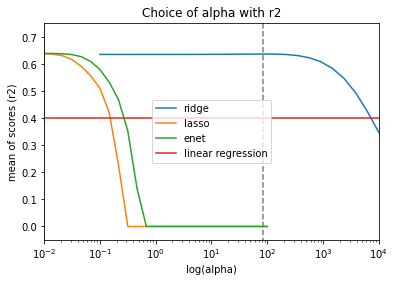

,score,execution_time,best_alpha
lr,0.4,0.08399,None
ridge,0.603432,0.735336,82.540419
lasso,0.193249,0.578278,0.01
enet,0.234575,0.728822,0.01


In [6]:
dict_param_grid = {"ridge": np.logspace(-1, 4, 25),
                   "lasso": np.logspace(-2, 2, 25),
                   "enet" : np.logspace(-2, 2, 25),
                  }

dict_models = {"ridge" : linear_model.Ridge(), 
               "lasso" : linear_model.Lasso(),
               "enet" : linear_model.ElasticNet(),
              }

var = "SiteEnergyUse(kBtu)"
X_ = X_std
y_ = np.log(y_std[var]+1)
print("for", var, "in log space :")
res = compare_regressions(X_, y_, dict_models, dict_param_grid, score_name="r2", fig_name=None)
plt.show()
res

for CO2_emissions in log space :


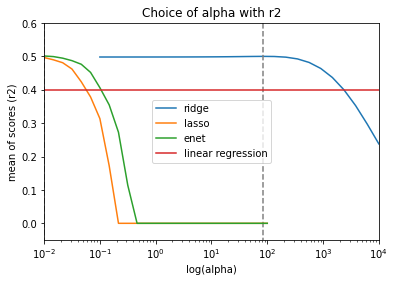

,score,execution_time,best_alpha
lr,0.4,0.047094,None
ridge,0.465687,0.847191,82.540419
lasso,0.128715,0.545207,0.01
enet,0.162351,0.545629,0.01


In [7]:
var = "CO2_emissions"
X_ = X_std
y_ = np.log(y_std[var]+1)
print("for", var, "in log space :")
res = compare_regressions(X_, y_, dict_models, dict_param_grid, score_name="r2", fig_name=None)
plt.show()
res

La régression linéaire, même avec pénalisation, ne semble pas produire un modèle de prédiction convainquant, notamment à cause de la lourde queue de distribution des variables à prédire. Néansmoins, je vais utiliser la régression pénalisée lasso sur les variables "catégorielles" (issues de la vectorisation de ces dernière pour être précise), afin de voir si certaines de mes modalités sont non significatives (et peuvent donc être retirées).

for SiteEnergyUse(kBtu) in log space :


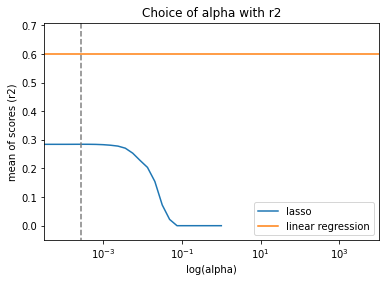

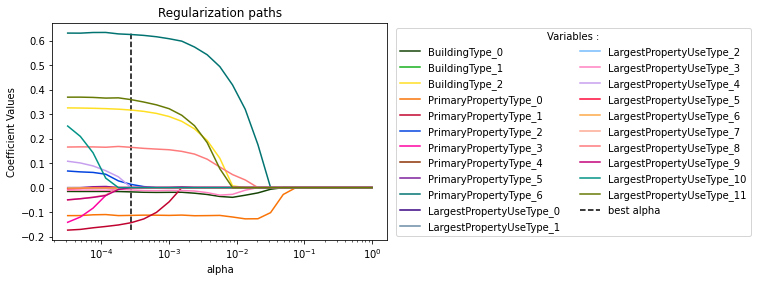

Modalities with zero coefficient in ANOVA :


Index(['BuildingType_0', 'BuildingType_2', 'PrimaryPropertyType_0',
       'PrimaryPropertyType_1', 'PrimaryPropertyType_2',
       'PrimaryPropertyType_6', 'LargestPropertyUseType_3',
       'LargestPropertyUseType_8', 'LargestPropertyUseType_11'],
      dtype='object')

In [8]:
dict_param_grid["lasso"] = np.logspace(-4.5, 0, 25)

var = "SiteEnergyUse(kBtu)"
X_ = X.loc[:,X.dtypes == int]
y_ = np.log(y_std[var]+1)

print("for", var, "in log space :")
res = compare_regressions(X_, y_, {"lasso" : linear_model.Lasso(max_iter=10000)}, 
                          dict_param_grid, score_name="r2", fig_name=None)
plt.show()
## regul paths :
model_name = "lasso"
legend_kwargs = {"loc" : "upper right","bbox_to_anchor":(2.1, 1), "ncol":2}
plot_regul_paths(alpha_values = dict_param_grid[model_name], lm_model = dict_models[model_name], 
                 X_ = X_, y_ = y_, best_alpha=res.loc[model_name, "best_alpha"],
                 var_names = X_.columns, legend_kwargs=legend_kwargs)
plt.show()

model = dict_models[model_name]
model.set_params(alpha = res.loc[model_name, "best_alpha"])
model.fit(X_,y_)
models_coefs = model.coef_
print("Modalities with zero coefficient in ANOVA :")
zero_coeff_modality = X_.columns[[abs(coef) > 10**(-5) for coef in models_coefs]]
zero_coeff_modality

Je vais donc retirer ces méta-modalités, car elle n'ont pas d'influence dans cette ANOVA. 

In [9]:
X = X.drop(zero_coeff_modality.values, axis =1)
X_std = pd.DataFrame(my_standardizer.fit_transform(X), columns=X.columns, index = X.index)

# Liste des modèles testés : 

Pour chacun des modèles de régression testé, j'ai construit un dictionnaire des arguments par défaut (```dict_kwargs_models```). Ce dictionnaire a les mêmes clés "modèles_de_regression" que les dictionnaires ```dict_models``` et ```dict_param_grid```, correspondant respectivement au dictionnaire des fonctions de regression (principalement de sklearn) et des hyper-paramètres à fixer par validation croisée.

In [10]:
dict_kwargs_models = {}
dict_models = {}
dict_param_grid = {}

y_co2 = y["CO2_emissions"]
y_energy = y["SiteEnergyUse(kBtu)"]


## 1. Régression à noyaux 

Est-ce que le lien entre les données serait mieux représenté dans un RKHS ? 

In [11]:
from sklearn.kernel_ridge import KernelRidge
model_name = "kernel_ridge"

dict_kwargs_models[model_name] = {"alpha":1, "kernel":'linear',"gamma":None,
                                  "degree":3, "coef0":1, "kernel_params":None}
dict_models[model_name] = KernelRidge(**dict_kwargs_models[model_name])
dict_param_grid[model_name] = {"alpha":np.logspace(0, 2, 20)}# regularisation param

## 2. KNN :

In [32]:
from sklearn.neighbors import KNeighborsRegressor
model_name = "KNN"

dict_kwargs_models[model_name] = {"n_neighbors":5, "weights":'uniform', "algorithm":'auto',
                                  "leaf_size":30, "p":2, "metric":'minkowski',
                                  "metric_params":None, "n_jobs":None}
dict_models[model_name] = KNeighborsRegressor(**dict_kwargs_models[model_name])
dict_param_grid[model_name] = {"n_neighbors":np.arange(1,10,1)}

KNN


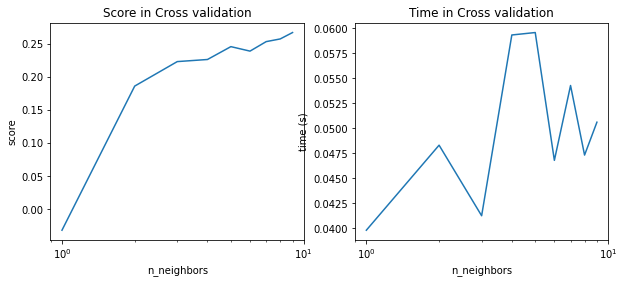

In [33]:
from sklearn.model_selection import GridSearchCV

print(model_name)
regressor = dict_models[model_name]
param_grid = dict_param_grid[model_name]
CV_regressor = GridSearchCV(regressor, param_grid, refit=True, cv = cv)
CV_regressor.fit(X_std, y_co2)
res = CV_regressor.cv_results_
dict_cv_results_[model_name] = res
if len(res["params"][0].keys())==1 : 
    cv_plot_score_and_time(res, True)


In [28]:
def cv_plot_score_and_time(res, x_log_scale = False):
    plt.figure(figsize=(10,4))
    x= [list(param.values())[0] for param in res["params"]]

    plt.subplot(1,2,1)
    if x_log_scale : 
        plt.xscale("log")
    plt.plot(x, res["mean_test_score"])
    plt.xlabel(list(res["params"][0].items())[0][0])#get param name 
    plt.ylabel("score")
    plt.title("Score in Cross validation")
    plt.subplot(1,2,2)
    if x_log_scale : 
        plt.xscale("log")
    plt.plot(x, res["mean_fit_time"]+ res["mean_score_time"])
    plt.xlabel(list(res["params"][0].items())[0][0])#get param name 
    plt.ylabel("time (s)")
    plt.title("Time in Cross validation")
    

## 3. SVM : 

In [35]:
from sklearn.svm import SVR
model_name = "SVR"

dict_kwargs_models[model_name] = {"kernel":'rbf', "degree":3, "gamma":'scale',
                          "coef0":0.0, "tol":0.001, "C":1.0, "epsilon":0.1}
dict_models[model_name] = SVR(**dict_kwargs_models[model_name])
dict_param_grid[model_name] = {"C":np.logspace(-1, 2, 10),# regularisation param
                               "epsilon":np.logspace(-2,1,10)}


In [ ]:
res

Il faut que je modifie mon format de dict_param_grid pour qu'il devienne dictionnaire de dictionnaire (avec le nom des hyper-params et leur valeurs, pour chaque modèle

Dans [l'aide de la fonction SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html), il y a une exemple d' utilisation de pipeline, à voir si ce n'est pas pertinent pour moi

## 4. Forêts aléatoires

In [ ]:
from sklearn.ensemble import RandomForestRegressor 
model_name = "random_forest"

dict_kwargs_models[model_name] = {"n_estimators":100, 
                                  "criterion":'mse', "max_depth":None, 
                                  "min_samples_split":2, "min_samples_leaf":1, 
                                  "min_weight_fraction_leaf":0.0, "max_features":'auto',
                                  "max_leaf_nodes":None, "min_impurity_decrease":0.0,
                                  "min_impurity_split":None, "bootstrap":True, "oob_score":False,
                                  "n_jobs":None, "random_state":None, "verbose":0, 
                                  "warm_start":False, "ccp_alpha":0.0, "max_samples":None}
dict_models[model_name] = RandomForestRegressor(**dict_kwargs_models[model_name])
dict_param_grid[model_name] = {"n_estimators":np.arange(50,250,50)}# regularisation param


# Résultats et interprétation : 
##TODO : define param_log_flag, to plot res in xscale("log")

In [34]:
from sklearn.model_selection import GridSearchCV
cv = 5
dict_cv_results_= {}
for model_name in dict_models.keys(): 
    regressor = dict_models[model_name]
    param_grid = dict_param_grid[model_name]
    CV_regressor = GridSearchCV(regressor, param_grid, refit=True, cv = cv)
    CV_regressor.fit(X, y)
    res = CV_regressor.cv_results_
    dict_cv_results_[model_name] = res
    if len(res["params"][0].keys())==1 : 
        cv_plot_score_and_time(res)
        if param_log_flag :
            plt.xscale("log")

KeyboardInterrupt: 

TypeError: float() argument must be a string or a number, not 'dict_values'

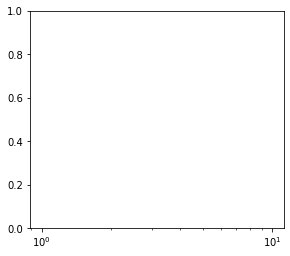

In [36]:
x_log_scale = True

list_dict_params = res["params"].copy()
dict_index_values = {}
for param in list_dict_params[0].keys() : 
    index_values = []
    param_values = np.unique([dict_params[param] for dict_params in list_dict_params ])
    for value in param_values :
        index_value = [dict_params[param] == value for dict_params in list_dict_params]
        index_values.append(index_value)
    dict_index_values[param] = index_value
    
    
    
nb_params = len(list_dict_params[0].keys())
plt.figure(figsize=(10,4*nb_params))
x= [param.values() for param in res["params"]]

fig_count = 1
plt.subplot(1,2,1)
if x_log_scale : 
    plt.xscale("log")
plt.plot(x, res["mean_test_score"])
plt.xlabel(list(res["params"][0].items())[0][0])#get param name 
plt.ylabel("score")
plt.title("Score in Cross validation")
plt.subplot(1,2,2)
if x_log_scale : 
    plt.xscale("log")
plt.plot(x, res["mean_fit_time"]+ res["mean_score_time"])
plt.xlabel(list(res["params"][0].items())[0][0])#get param name 
plt.ylabel("time (s)")
plt.title("Time in Cross validation")

In [ ]:
index_value